# Strategies to prevent overfitting in neural networks

In [2]:
# !pip install tensorflow==2.1 --user

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

try:
    tf.set_random_seed(1337)                    # set the random seed for reproducibility
except:
    tf.random.set_seed(1337)                     # NOTE: Newer version of tensorflow uses tf.random.set_seed
np.random.seed(1337)                         #       instead of tf.set_random_seed

## Introduction

**Business Context.** You are a data scientist working for a machine learning consultancy. One of your clients wants to be able to classify text reviews automatically by the likely rating (on a 1 - 5 scale) that that person would give. However, they do not have sufficient data they generated on their own to do this, so you need to use an external, rich dataset as a basis on which to build your model and then translate it over.

**Business Problem.** Your task is to **build a neural networks-based model for classifying text reviews into likely ratings (on a 1 - 5 scale)**.

**Analytical Context.** We'll use the Amazon review dataset again and try to classify reviews into star ratings automatically. Instead of just positive and negative, we'll take on the harder challenge of predicting the *exact* star rating. The lowest score is 1 and the highest is 5.

Instead of trying to optimize by pre-processing the text, we'll do very basic tokenization and experiment with different neural network models, architectures, and hyperparameters to optimize the results. You'll start by building a simple dense neural network and try to get it to perform better using various techniques. Then you'll evaluate the results and diagnose where it tends to perform more poorly.

## Setting up and preparing the data

We'll mainly be using the `keras` module from TensorFlow, but we'll also use `pandas` to read the CSV file and `sklearn` for some helper functions. We'll be using only the "Text" and "Score" columns in the `Reviews.csv` file:

In [2]:
amazon_reviews = pd.read_csv('Reviews.csv', nrows=262084)
amazon_reviews.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Exercise 1:

Combine the first 1,000 of each of the 1-, 2-, 3-, 4-, and 5-star reviews in `amazon_reviews` into a single DataFrame (so you should have 5,000 observations in total). Split this DataFrame into training and test sets, with 80% of the data for the training set.

**Hint:** `keras` will expected your labels to start with 0, and not 1, so make sure to adjust the labels accordingly.

In [3]:
amazon_rev_sorted = amazon_reviews.sort_values(by="Score")[["Score","Text"]]

amazon_rev_reduced = amazon_rev_sorted.groupby(["Score"]).head(1000)
amazon_rev_reduced.Score = amazon_rev_reduced.Score.apply(lambda x: x-1)
# amazon_rev_reduced[amazon_rev_reduced.Score == 0]

rev_train, rev_test = train_test_split(amazon_rev_reduced, train_size=0.8, random_state=100)


C:\Conda\envs\extended_case_7\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


**Answer.**

------------

## Tokenizing our texts

Keras comes with its own functions to preprocess text, including a [tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) (a mapping from each word in our corpus to a unique integer). Unlike the `CountVectorizer` from `sklearn`, which produces sparse matrices, `keras` often expects to work with sequences representing only the words that occur in a text. To prepare text before feeding it into a neural network, we usually:

1. Create a [tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).
2. [Create sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences) from our text (each text becomes a list of integers, based on the tokenizer mapping, instead of words)
3. [Pad or truncate](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) each sequence to a fixed length (very short texts get `0`s added to them, while very long ones are truncated).

The tokenizer has a configurable word cap, so it will only consider the $n$ most common words in the corpus, ignoring very rare words.

### Exercise 2:

In this exercise, you will learn how to use the `tf.keras.preprocessing.text.Tokenizer` tool to carry out the preprocessing steps described above.

#### 2.1

Perform some exploratory analysis of the dataset to calculate the number of unique words in our corpus and the distribution of the number of words in each review of the training set. What is the 80th percentile of this distribution?

In [4]:
import re 

amazon_rev_reduced["text_new"] = amazon_rev_reduced.Text.apply(lambda x: x.lower())

special_chars = amazon_rev_reduced.text_new.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])
flat_list = [item for sublist in special_chars for item in sublist]
# print(set(flat_list))

amazon_rev_reduced_orig = amazon_rev_reduced.copy()

amazon_rev_reduced.text_new = amazon_rev_reduced.text_new.apply(
    lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

words_orig = amazon_rev_reduced.Text.apply(lambda x: x.split(" "))
words_orig = [word for sublist in words_orig for word in sublist]

words_prep = amazon_rev_reduced.text_new.apply(lambda x: x.split(" "))
words_prep = [word.strip() for words in words_prep for word in words]

print(f"There are {len(set(words_orig))} different words in the original corpus")
print(f"The 80th percentile is: ", int(len(set(words_orig)) * 0.8))

print(f"There are {len(set(words_prep))} different words in the corpus after using only lowercase and removing special characters")
print(f"The 80th percentile is: {int(len(set(words_prep)) * 0.8)}")

# amazon_rev_reduced.head()
# amazon_rev_reduced.text_new

C:\Conda\envs\extended_case_7\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


There are 37138 different words in the original corpus
The 80th percentile is:  29710
There are 14962 different words in the corpus after using only lowercase and removing special characters
The 80th percentile is: 11969


Text(0.5, 1.0, 'Histogram of number of words per review in the train dataset')

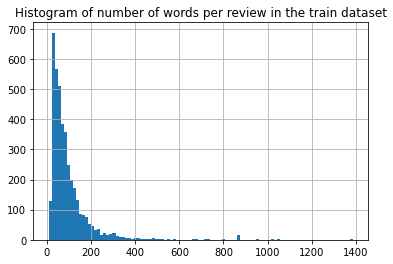

In [5]:
import matplotlib.pyplot as plt
words_per_review = rev_train.Text.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)

plt.title("Histogram of number of words per review in the train dataset")

In [6]:
words_per_review.describe()

count    4000.000000
mean       93.326000
std        98.810504
min         7.000000
25%        38.000000
50%        65.000000
75%       112.000000
max      1387.000000
Name: Text, dtype: float64

In [7]:
words_per_review.mean()

93.326

In [8]:
print("In the train dataset, the 80th quantile of the number of words per review is",words_per_review.quantile(0.8))

In the train dataset, the 80th quantile of the number of words per review is 127.0


**Answer.**

------------

#### 2.2

Given the results above, we create a tokenizer using only the top 20,000 most frequent words in our corpus (which corresponds to roughly 80% of the words): 

In [9]:
tokenizer = Tokenizer(num_words=20000) #We create the tokenizer using only top 20000 words

In [10]:
tokenizer.fit_on_texts(rev_train['Text'])  #Then, we create the text->indices mapping. 

The above line has given several features and methods to our tokenizer. For instance, print the line `tokenizer.word_index` in a new cell - what do you see? Apply the `tokenizer.texts_to_sequences()` method on the list `['I just feel very very good']`. Apply the `tokenizer.sequences_to_texts()` method on the list `[[109, 19, 824, 76, 114, 6315, 1137, 8070]]`. What were your results?

In [11]:
tokenizer.word_index

{'the': 1,
 'i': 2,
 'a': 3,
 'and': 4,
 'to': 5,
 'it': 6,
 'of': 7,
 'br': 8,
 'is': 9,
 'this': 10,
 'in': 11,
 'for': 12,
 'that': 13,
 'my': 14,
 'but': 15,
 'not': 16,
 'was': 17,
 'with': 18,
 'have': 19,
 'you': 20,
 'as': 21,
 'like': 22,
 'are': 23,
 'they': 24,
 'so': 25,
 'on': 26,
 'be': 27,
 'these': 28,
 'good': 29,
 'taste': 30,
 'them': 31,
 'if': 32,
 'product': 33,
 'just': 34,
 'coffee': 35,
 'or': 36,
 'one': 37,
 'at': 38,
 'more': 39,
 'very': 40,
 'would': 41,
 'all': 42,
 'from': 43,
 'food': 44,
 'out': 45,
 'flavor': 46,
 'had': 47,
 'me': 48,
 "it's": 49,
 'can': 50,
 'when': 51,
 'will': 52,
 'has': 53,
 'get': 54,
 'no': 55,
 'really': 56,
 'than': 57,
 'we': 58,
 'because': 59,
 'other': 60,
 'she': 61,
 'about': 62,
 'great': 63,
 'up': 64,
 'some': 65,
 'much': 66,
 "don't": 67,
 'only': 68,
 'too': 69,
 'were': 70,
 'what': 71,
 'an': 72,
 'there': 73,
 'your': 74,
 'tea': 75,
 'little': 76,
 'even': 77,
 'do': 78,
 'which': 79,
 'amazon': 80,
 'by': 8

The tokenizer converts all the words to lower case, removes most of the separators by default (unless specific ones are chosen) and assigns a value to each word, most likely using the tf-idf method to order the words in the returned dictionary. Therefore, we can see that the word_index method returns the words and they are order from most common to less common.

In [12]:
tokenizer.texts_to_sequences(['I just feel very very good'])

[[2, 34, 268, 40, 40, 29]]

In [13]:
tokenizer.sequences_to_texts([[109, 19, 824, 76, 114, 6315, 1137, 8070]])

['make have simply little think rabbits beer eggwhite']

**Answer.**

The texts_to_sequences method simply matches each word to its token. Returning the integer value paired to each word if it exists in the tokenizer. Conversely, the sequences_to_texts takes list of integers and returns the words matched to each of those integers, if they exist.

------------

#### 2.3

Use the tokenizer to transform the texts in our test and train data to sequences. Then, use the `pad_sequences` function to pad/truncate these sequences to length 116 (the 80th percentile of text lengths). Save the resulting arrays as `train_sequences` and `test_sequences`.

In [14]:
train_seq = tokenizer.texts_to_sequences(rev_train.Text)
test_seq = tokenizer.texts_to_sequences(rev_test.Text)
train_sequences = pad_sequences(
    train_seq, maxlen=116, dtype='int32', padding='pre', truncating='pre',
    value=0.0)
test_sequences = pad_sequences(
    test_seq, maxlen=116, dtype='int32', padding='pre', truncating='pre',
    value=0.0)


In [15]:
train_labels = rev_train.Score
test_labels = rev_test.Score

**Answer.**

------------

## Building a basic neural network model 

Now that we have preprocessed the text, let's create a basic neural network to train on our data. We'll use an embedding layer which performs [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) on our word sequences, two fully connected ("dense") layers, and an output layer with 5 neurons to represent the 5 possible star ratings.

Before we train a `keras` model, there is an additional `compile` step where we define what loss function and optimizer to use, and what metrics to output. Then we can train the model using the `fit` function. All of this is shown below.

Note the `validation_split=0.2` argument which tells Keras to train on only 80% of the training data and tune the model on the remaining 20%, which we call the validation set. You can see the accuracy and loss for both the training and validation set in the output for each epoch:

In [36]:
model = Sequential()
model.add(Embedding(20000, 128, input_length=116))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 116, 128)          2560000   
_________________________________________________________________
dense_3 (Dense)              (None, 116, 128)          16512     
_________________________________________________________________
dense_4 (Dense)              (None, 116, 128)          16512     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 2,593,669
Trainable params: 2,593,669
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = model.fit(train_sequences, train_labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.5884 - accuracy: 0.3050 - val_loss: 1.5270 - val_accuracy: 0.4025
Epoch 2/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.3286 - accuracy: 0.4875 - val_loss: 1.2604 - val_accuracy: 0.4663
Epoch 3/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.9667 - accuracy: 0.6456 - val_loss: 1.2167 - val_accuracy: 0.4863
Epoch 4/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.6143 - accuracy: 0.8044 - val_loss: 1.3429 - val_accuracy: 0.4863
Epoch 5/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.3197 - accuracy: 0.9150 - val_loss: 1.5248 - val_accuracy: 0.4762
Epoch 6/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.1440 - accuracy: 0.9734 - val_loss: 1.7319 - val_accuracy: 0.4725
Epoch 7/10
3200/3200 [==============================] - 5s 2ms/sample - loss:

### Exercise 3:

How well does this model perform? How does this compare to a baseline expectation? What do you notice about the accuracy and loss values for both the validation and training sets over time and what does this mean?

Text(0.5, 1.0, 'Model performance')

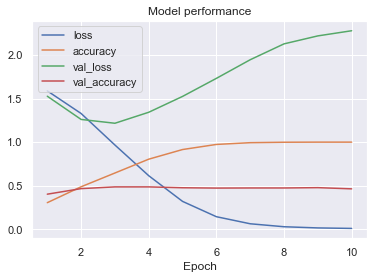

In [57]:
data = history.history
# print(data)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.lineplot(x=range(1,11), y=data["loss"])
ax = sns.lineplot(x=range(1,11), y=data["accuracy"])
ax = sns.lineplot(x=range(1,11), y=data["val_loss"])
ax = sns.lineplot(x=range(1,11), y=data["val_accuracy"])
ax.legend(['loss',"accuracy","val_loss","val_accuracy"])
plt.xlabel("Epoch")
plt.title("Model performance")

**Answer.**

We can see that this model performs extremely well on the train set but not so much on the validation set. In fact, the accuracy even after several runs does not change much. Also, the loss of the train set decreases continuously down to zero while the loss of the validation quickly reaches a minimum at the 3rd epoch and then starts increasing again. This is a signal that the model is not learning from that epoch forward. We could say that the model does not perform very well. It could also be a signal of overfitting of the model on the train dataset and that is why it underperforms after the 3rd epoch.

Nevertheless, if we think of a baseline model that predicts all reviews with the same Score, we would have a baseline accuracy of around 20% because we defined 5000 as the whole dataset, 4000 for training the model and 3200/800 for train/val. A baseline model would correctly predict 1000 scores correctly. Currently, the model would be predicting roughly 50% at the validation level. 

------------

## Experimenting with different regularization strategies

There are many different ways to mitigate overfitting in a neural network, collectively known as *regularization* techniques. One common regularization technique is called [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout). In this regularization method, a set of neurons is randomly selected at each training step to be completely ignored. This is done so that the neurons in our network do not rely strongly on their neighboring neurons and we avoid the creation of ["co-adaptations"](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) that do not generalize well to unseen data. This making the model more robust and less prone to overffiting.

You can create dropouts in `keras` by adding a layer named `Dropout(p)`, where `p` is the probability of dropping neurons in the previous layer. For example, the following model would implement dropout by removing roughly 20% percent of the outputs of the embedding layer at each training step:

In [60]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu')) 
model2.add(Dense(128, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_4_0 = model2.fit(train_sequences, train_labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.5939 - accuracy: 0.2666 - val_loss: 1.5480 - val_accuracy: 0.3150
Epoch 2/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.3989 - accuracy: 0.4075 - val_loss: 1.3101 - val_accuracy: 0.4375
Epoch 3/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.1285 - accuracy: 0.5581 - val_loss: 1.2332 - val_accuracy: 0.4775
Epoch 4/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.8419 - accuracy: 0.6853 - val_loss: 1.2571 - val_accuracy: 0.4850
Epoch 5/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.5619 - accuracy: 0.8172 - val_loss: 1.3132 - val_accuracy: 0.5025
Epoch 6/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.3340 - accuracy: 0.9056 - val_loss: 1.4707 - val_accuracy: 0.4913
Epoch 7/10
3200/3200 [==============================] - 5s 2ms/sample - loss:

### Exercise 4:

Modify the neural network definition above to try and fix the overfitting problem using Dropout. Explain the configuration that you tried and your results. Why do you think your modifications were or were not able to mitigate the overfitting problem?

In [61]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu')) 
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_4_1 = model2.fit(train_sequences, train_labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.5983 - accuracy: 0.2444 - val_loss: 1.5727 - val_accuracy: 0.3075
Epoch 2/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.4749 - accuracy: 0.3644 - val_loss: 1.3903 - val_accuracy: 0.4025
Epoch 3/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.2442 - accuracy: 0.4834 - val_loss: 1.2606 - val_accuracy: 0.4675
Epoch 4/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.0204 - accuracy: 0.5931 - val_loss: 1.2282 - val_accuracy: 0.4675
Epoch 5/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.8115 - accuracy: 0.6966 - val_loss: 1.2667 - val_accuracy: 0.4825
Epoch 6/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.5961 - accuracy: 0.7953 - val_loss: 1.3502 - val_accuracy: 0.4762
Epoch 7/10
3200/3200 [==============================] - 6s 2ms/sample - loss:

In [66]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dense(128, activation='relu')) 
model2.add(Dropout(0.1))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.1))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_4_2 = model2.fit(train_sequences, train_labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.5940 - accuracy: 0.2594 - val_loss: 1.5612 - val_accuracy: 0.3550
Epoch 2/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.3959 - accuracy: 0.4384 - val_loss: 1.2918 - val_accuracy: 0.4613
Epoch 3/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.0775 - accuracy: 0.5794 - val_loss: 1.2184 - val_accuracy: 0.4888
Epoch 4/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.8068 - accuracy: 0.6994 - val_loss: 1.2161 - val_accuracy: 0.4863
Epoch 5/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.5462 - accuracy: 0.8181 - val_loss: 1.3182 - val_accuracy: 0.5025
Epoch 6/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.3153 - accuracy: 0.9159 - val_loss: 1.4761 - val_accuracy: 0.5138
Epoch 7/10
3200/3200 [==============================] - 6s 2ms/sample - loss:

In [63]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu')) 
model2.add(Dropout(0.1))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.1))
model2.add(GlobalMaxPooling1D())
model2.add(Dropout(0.1))
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_4_3 = model2.fit(train_sequences, train_labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.6005 - accuracy: 0.2500 - val_loss: 1.5768 - val_accuracy: 0.3113
Epoch 2/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.4725 - accuracy: 0.3684 - val_loss: 1.3657 - val_accuracy: 0.4175
Epoch 3/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.2347 - accuracy: 0.4875 - val_loss: 1.2437 - val_accuracy: 0.4563
Epoch 4/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.0122 - accuracy: 0.6112 - val_loss: 1.2225 - val_accuracy: 0.4775
Epoch 5/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.7841 - accuracy: 0.7103 - val_loss: 1.2767 - val_accuracy: 0.4850
Epoch 6/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.5733 - accuracy: 0.8075 - val_loss: 1.3779 - val_accuracy: 0.4762
Epoch 7/10
3200/3200 [==============================] - 6s 2ms/sample - loss:

In [64]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu')) 
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.1))
model2.add(GlobalMaxPooling1D())
model2.add(Dropout(0.1))
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_4_4 = model2.fit(train_sequences, train_labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.5967 - accuracy: 0.2553 - val_loss: 1.5584 - val_accuracy: 0.3313
Epoch 2/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.4298 - accuracy: 0.4122 - val_loss: 1.3261 - val_accuracy: 0.4387
Epoch 3/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.1858 - accuracy: 0.5206 - val_loss: 1.2328 - val_accuracy: 0.4625
Epoch 4/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.9509 - accuracy: 0.6297 - val_loss: 1.2506 - val_accuracy: 0.4812
Epoch 5/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.7137 - accuracy: 0.7391 - val_loss: 1.3276 - val_accuracy: 0.4837
Epoch 6/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.4930 - accuracy: 0.8359 - val_loss: 1.4589 - val_accuracy: 0.4575
Epoch 7/10
3200/3200 [==============================] - 6s 2ms/sample - loss:

In [65]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dropout(0.3)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu')) 
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_4_5 = model2.fit(train_sequences, train_labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.5968 - accuracy: 0.2481 - val_loss: 1.5685 - val_accuracy: 0.3050
Epoch 2/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.4526 - accuracy: 0.3700 - val_loss: 1.3839 - val_accuracy: 0.3988
Epoch 3/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.2098 - accuracy: 0.5116 - val_loss: 1.2720 - val_accuracy: 0.4500
Epoch 4/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.9823 - accuracy: 0.6100 - val_loss: 1.2496 - val_accuracy: 0.4700
Epoch 5/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.7515 - accuracy: 0.7294 - val_loss: 1.2791 - val_accuracy: 0.4775
Epoch 6/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.5318 - accuracy: 0.8300 - val_loss: 1.3728 - val_accuracy: 0.4787
Epoch 7/10
3200/3200 [==============================] - 6s 2ms/sample - loss:

**Answer.**

From the 5 models tried, we can see that history_4_2 has the highest validation accuracy during validation: 51.38%. Slightly higher than the best validation accuracy (50.50%) for the first model with dropout (history_4_0). This results might not be significantly different, as the dropout turns off randomly a defined percentage of the neurons and not always the same. 

It is noticeable how using a dropout over 0.2 tends to decrease the performance of the model overall. This is likely to result in giving too much load to few neurons that cannot generalize correctly for the validation dataset.

Also, the idea of the best performing model comes from the fact that setting a lower (0.1) dropout in two consecutive layers means that every epoch, these two layers will have different neurons to fit the data and will force the network to better generalize for the fewer neurons and connections. This is also seen in the paper of Srivastava, where the dropout networks that outperform tend to have dropouts in several layers. The accuracy, nevertheless, does not improve greatly with this technique.

In my opinion, the model is not improving greatly either because there is simply not enough data or the data is very similar and the model cannot avoid overfitting with the parameters as have been set up so far.

------------

### Exercise 5:

Keras allows you to add [L1](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1), [L2](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2), or [L1 and L2](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1_l2) combined regularizers on individual layers by passing in the `kernel_regularizer`, `bias_regularizer` or `activity_regularizer` arguments. In neural networks, these regularizers work by penalizing the loss function in different ways, based on the number of weights or the size of the weights.

Try 4-5 different combinations of L1, L2, L1 and L2 regularization in different combinations on different layers. In each example, explain why you tried that configuration and the results. Why do you think your modifications were or were not able to mitigate the overfitting problem?

In [69]:
# regularizers.l1_l2(l1=0.01, l2=0.01)
# regularizers.l1(l=0.01)
# regularizers.l2(l=0.01)

model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dense(128, activation='relu', kernel_regularizer = regularizers.l2(l=0.0001))) 
model2.add(Dropout(0.1))
model2.add(Dense(128, activation='relu', kernel_regularizer = regularizers.l2(l=0.0001)))
model2.add(Dropout(0.1))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_5_0 = model2.fit(train_sequences, train_labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.6212 - accuracy: 0.2731 - val_loss: 1.5921 - val_accuracy: 0.3837
Epoch 2/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.4272 - accuracy: 0.4422 - val_loss: 1.3120 - val_accuracy: 0.4762
Epoch 3/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.1058 - accuracy: 0.5972 - val_loss: 1.2652 - val_accuracy: 0.4800
Epoch 4/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.8236 - accuracy: 0.7153 - val_loss: 1.3222 - val_accuracy: 0.4712
Epoch 5/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.5619 - accuracy: 0.8247 - val_loss: 1.4474 - val_accuracy: 0.4737
Epoch 6/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.3503 - accuracy: 0.9078 - val_loss: 1.6396 - val_accuracy: 0.4638
Epoch 7/10
3200/3200 [==============================] - 5s 2ms/sample - loss:

In [74]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dense(128, activation='relu', kernel_regularizer = regularizers.l1_l2(l1=0.0001, l2=0.0001))) 
model2.add(Dropout(0.1))
model2.add(Dense(128, activation='relu', kernel_regularizer = regularizers.l1_l2(l1=0.0001, l2=0.0001)))
model2.add(Dropout(0.1))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_5_1 = model2.fit(train_sequences, train_labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.8016 - accuracy: 0.2416 - val_loss: 1.7234 - val_accuracy: 0.3200
Epoch 2/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.6221 - accuracy: 0.3613 - val_loss: 1.5064 - val_accuracy: 0.4225
Epoch 3/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.3710 - accuracy: 0.4684 - val_loss: 1.4223 - val_accuracy: 0.4288
Epoch 4/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.1653 - accuracy: 0.5809 - val_loss: 1.4407 - val_accuracy: 0.4350
Epoch 5/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.9565 - accuracy: 0.6769 - val_loss: 1.5584 - val_accuracy: 0.4450
Epoch 6/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.7711 - accuracy: 0.7672 - val_loss: 1.6583 - val_accuracy: 0.4538
Epoch 7/10
3200/3200 [==============================] - 5s 2ms/sample - loss:

In [75]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dense(128, activation='relu', bias_regularizer = regularizers.l2(l=0.0001))) 
model2.add(Dropout(0.1))
model2.add(Dense(128, activation='relu', bias_regularizer = regularizers.l2(l=0.0001)))
model2.add(Dropout(0.1))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_5_2 = model2.fit(train_sequences, train_labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.5902 - accuracy: 0.2678 - val_loss: 1.5411 - val_accuracy: 0.3512
Epoch 2/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.3744 - accuracy: 0.4338 - val_loss: 1.2920 - val_accuracy: 0.4675
Epoch 3/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.0640 - accuracy: 0.5925 - val_loss: 1.2247 - val_accuracy: 0.4650
Epoch 4/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.7599 - accuracy: 0.7247 - val_loss: 1.2743 - val_accuracy: 0.4837
Epoch 5/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.4806 - accuracy: 0.8462 - val_loss: 1.3971 - val_accuracy: 0.4762
Epoch 6/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.2790 - accuracy: 0.9212 - val_loss: 1.6037 - val_accuracy: 0.4613
Epoch 7/10
3200/3200 [==============================] - 5s 2ms/sample - loss:

In [77]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dense(128, activation='relu', bias_regularizer = regularizers.l1_l2(l1=0.00001, l2=0.0001)))
model2.add(Dropout(0.1))
model2.add(Dense(128, activation='relu', bias_regularizer = regularizers.l1_l2(l1=0.00001, l2=0.0001)))
model2.add(Dropout(0.1))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_5_3 = model2.fit(train_sequences, train_labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.5845 - accuracy: 0.2763 - val_loss: 1.5095 - val_accuracy: 0.3700
Epoch 2/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.3783 - accuracy: 0.4428 - val_loss: 1.3293 - val_accuracy: 0.4062
Epoch 3/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.0925 - accuracy: 0.5756 - val_loss: 1.2504 - val_accuracy: 0.4650
Epoch 4/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.8112 - accuracy: 0.6966 - val_loss: 1.3179 - val_accuracy: 0.4650
Epoch 5/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.5327 - accuracy: 0.8228 - val_loss: 1.4176 - val_accuracy: 0.4737
Epoch 6/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.3139 - accuracy: 0.9106 - val_loss: 1.6133 - val_accuracy: 0.4663
Epoch 7/10
3200/3200 [==============================] - 5s 2ms/sample - loss:

In [72]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dense(128, activation='relu', activity_regularizer = regularizers.l2(l=0.001))) 
model2.add(Dropout(0.1))
model2.add(Dense(128, activation='relu', activity_regularizer = regularizers.l2(l=0.001)))
model2.add(Dropout(0.1))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_5_4 = model2.fit(train_sequences, train_labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.5996 - accuracy: 0.2800 - val_loss: 1.5633 - val_accuracy: 0.4000
Epoch 2/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.4266 - accuracy: 0.4419 - val_loss: 1.3537 - val_accuracy: 0.4450
Epoch 3/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.1597 - accuracy: 0.5678 - val_loss: 1.2721 - val_accuracy: 0.4762
Epoch 4/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.8749 - accuracy: 0.7075 - val_loss: 1.3115 - val_accuracy: 0.4775
Epoch 5/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.5804 - accuracy: 0.8537 - val_loss: 1.4201 - val_accuracy: 0.4800
Epoch 6/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.3910 - accuracy: 0.9291 - val_loss: 1.5267 - val_accuracy: 0.4725
Epoch 7/10
3200/3200 [==============================] - 5s 2ms/sample - loss:

In [80]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dense(128, activation='relu', activity_regularizer = regularizers.l1_l2(l1=0, l2=0.0001))) 
model2.add(Dropout(0.1))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.1))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_5_5 = model2.fit(train_sequences, train_labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.5815 - accuracy: 0.2894 - val_loss: 1.5133 - val_accuracy: 0.3625
Epoch 2/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.3832 - accuracy: 0.4288 - val_loss: 1.3125 - val_accuracy: 0.4487
Epoch 3/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.0974 - accuracy: 0.5628 - val_loss: 1.2335 - val_accuracy: 0.4900
Epoch 4/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.8055 - accuracy: 0.6997 - val_loss: 1.2793 - val_accuracy: 0.4888
Epoch 5/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.5270 - accuracy: 0.8291 - val_loss: 1.4288 - val_accuracy: 0.4712
Epoch 6/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.3204 - accuracy: 0.9100 - val_loss: 1.5851 - val_accuracy: 0.4600
Epoch 7/10
3200/3200 [==============================] - 5s 2ms/sample - loss:

In [82]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dense(128, activation='relu', activity_regularizer = regularizers.l1_l2(l1=0, l2=0.0001))) 
model2.add(Dense(128, activation='relu', activity_regularizer = regularizers.l1_l2(l1=0, l2=0.0001)))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_5_6 = model2.fit(train_sequences, train_labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.5939 - accuracy: 0.2756 - val_loss: 1.5525 - val_accuracy: 0.3963
Epoch 2/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 1.3703 - accuracy: 0.4731 - val_loss: 1.2983 - val_accuracy: 0.4525
Epoch 3/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 1.0140 - accuracy: 0.6306 - val_loss: 1.2705 - val_accuracy: 0.4775
Epoch 4/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 0.6665 - accuracy: 0.7866 - val_loss: 1.3764 - val_accuracy: 0.4837
Epoch 5/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 0.3743 - accuracy: 0.9091 - val_loss: 1.5576 - val_accuracy: 0.4775
Epoch 6/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 0.1939 - accuracy: 0.9753 - val_loss: 1.7411 - val_accuracy: 0.4750
Epoch 7/10
3200/3200 [==============================] - 5s 2ms/sample - loss:

**Answer.**

After adding different kinds of regularizations to the dense layers, in no case, there was an improvement over the model with dropout. It is important to note that i used the model with dropout in order to keep building upon the previous improvement.

The regularizations L1 and L2 were chosen between 0 and 1e-5. This is given the recommendations in the literature as summarized in https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/. Also, applying L1 and L2 regularizations to the kernels, bias and activity did not show promising results, as the model kept obtaining similar results to the initial ones.

More trials were done with values closer to 0 but for these values the regularization was so high that the network ended up not learning at all. Therefore, the impact was only seen with values between 0.001 and 0.0001.

Also, regularizing only one layer instead of both showed the same results.

When regularizing the model without the dropout, the results were very similar to adding the dropout only.

Also, we could say that the regularization makes the nn more patience and avoid overfitting. Nevertheless, in this case, the nn seems to keep reaching a maximum of accuracy around 50%.

------------

## Regularization through adding more data

Depending on the configurations you tried above, you probably saw that L1 and L2 regularization are pretty limited for this model and this amount of data. A more straightforward way to prevent overfitting is simply by adding more training data. If the network has more (and more varied) examples to learn from, perhaps it will learn more generalizable rules.

### Exercise 6:

How would you test the hypothesis that adding more data would result in a more generalizable model? Explain any change in results you see from further experimentation.

**Hint:** Try adding 6000 reviews for each score instead. Compare with the original proposed model.

In [87]:
amazon_rev_reduced_6 = amazon_rev_sorted.groupby(["Score"]).head(6000)
amazon_rev_reduced_6.Score = amazon_rev_reduced_6.Score.apply(lambda x: x-1)
# amazon_rev_reduced[amazon_rev_reduced.Score == 0]

rev_train_6, rev_test_6 = train_test_split(amazon_rev_reduced_6, train_size=0.8, random_state=100)

C:\Conda\envs\extended_case_7\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Text(0.5, 1.0, 'Histogram of number of words per review in the train dataset')

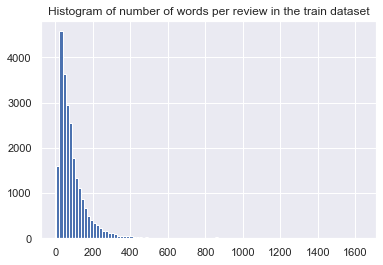

In [88]:
words_per_review_6 = rev_train_6.Text.apply(lambda x: len(x.split(" ")))
words_per_review_6.hist(bins = 100)

plt.title("Histogram of number of words per review in the train dataset")

In [89]:
print("In the train dataset, the 80th quantile of the number of words per review is",words_per_review_6.quantile(0.8))

In the train dataset, the 80th quantile of the number of words per review is 131.0


In [92]:
words_orig_6 = amazon_rev_reduced_6.Text.apply(lambda x: x.split(" "))
words_orig_6 = [word for sublist in words_orig_6 for word in sublist]
print(f"There are {len(set(words_orig_6))} different words in the original corpus")
print(f"The 80th percentile is: ", int(len(set(words_orig_6)) * 0.8))

amazon_rev_reduced_6["text_new"] = amazon_rev_reduced_6.Text.apply(lambda x: x.lower())

special_chars = amazon_rev_reduced_6.text_new.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])
flat_list = [item for sublist in special_chars for item in sublist]
# print(set(flat_list))

amazon_rev_reduced_6.text_new = amazon_rev_reduced_6.text_new.apply(
    lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
words_prep_6 = amazon_rev_reduced_6.text_new.apply(lambda x: x.split(" "))
words_prep_6 = [word.strip() for words in words_prep_6 for word in words]
print(f"There are {len(set(words_prep_6))} different words in the corpus after using only lowercase and removing special characters")
print(f"The 80th percentile is: {int(len(set(words_prep_6)) * 0.8)}")

There are 112964 different words in the original corpus
The 80th percentile is:  90371


C:\Conda\envs\extended_case_7\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


There are 33973 different words in the corpus after using only lowercase and removing special characters
The 80th percentile is: 27178


In [93]:
train_seq_6 = tokenizer.texts_to_sequences(rev_train_6.Text)
test_seq_6 = tokenizer.texts_to_sequences(rev_test_6.Text)
train_sequences_6 = pad_sequences(
    train_seq_6, maxlen=116, dtype='int32', padding='pre', truncating='pre',
    value=0.0)
test_sequences_6 = pad_sequences(
    test_seq_6, maxlen=116, dtype='int32', padding='pre', truncating='pre',
    value=0.0)

train_labels_6 = rev_train_6.Score
test_labels_6 = rev_test_6.Score

In [94]:
model = Sequential()
model.add(Embedding(20000, 128, input_length=116))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_6_0 = model.fit(train_sequences_6, train_labels_6, validation_split=0.2, epochs=10)

Train on 19200 samples, validate on 4800 samples
Epoch 1/10
19200/19200 [==============================] - 26s 1ms/sample - loss: 1.3609 - accuracy: 0.4061 - val_loss: 1.2311 - val_accuracy: 0.4762
Epoch 2/10
19200/19200 [==============================] - 25s 1ms/sample - loss: 1.0945 - accuracy: 0.5424 - val_loss: 1.2072 - val_accuracy: 0.5004
Epoch 3/10
19200/19200 [==============================] - 25s 1ms/sample - loss: 0.9295 - accuracy: 0.6261 - val_loss: 1.2006 - val_accuracy: 0.5123
Epoch 4/10
19200/19200 [==============================] - 24s 1ms/sample - loss: 0.7751 - accuracy: 0.7027 - val_loss: 1.2415 - val_accuracy: 0.5231
Epoch 5/10
19200/19200 [==============================] - 24s 1ms/sample - loss: 0.6430 - accuracy: 0.7606 - val_loss: 1.3667 - val_accuracy: 0.5235
Epoch 6/10
19200/19200 [==============================] - 24s 1ms/sample - loss: 0.5178 - accuracy: 0.8147 - val_loss: 1.4809 - val_accuracy: 0.5298
Epoch 7/10
19200/19200 [==============================] -

In [95]:
model = Sequential()
model.add(Embedding(30000, 128, input_length=116))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_6_1 = model.fit(train_sequences_6, train_labels_6, validation_split=0.2, epochs=10)

Train on 19200 samples, validate on 4800 samples
Epoch 1/10
19200/19200 [==============================] - 38s 2ms/sample - loss: 1.3680 - accuracy: 0.4022 - val_loss: 1.2371 - val_accuracy: 0.4702
Epoch 2/10
19200/19200 [==============================] - 37s 2ms/sample - loss: 1.1065 - accuracy: 0.5349 - val_loss: 1.2027 - val_accuracy: 0.4975
Epoch 3/10
19200/19200 [==============================] - 38s 2ms/sample - loss: 0.9504 - accuracy: 0.6152 - val_loss: 1.1915 - val_accuracy: 0.5158
Epoch 4/10
19200/19200 [==============================] - 38s 2ms/sample - loss: 0.7989 - accuracy: 0.6934 - val_loss: 1.2387 - val_accuracy: 0.5294
Epoch 5/10
19200/19200 [==============================] - 39s 2ms/sample - loss: 0.6709 - accuracy: 0.7479 - val_loss: 1.3353 - val_accuracy: 0.5200
Epoch 6/10
19200/19200 [==============================] - 38s 2ms/sample - loss: 0.5527 - accuracy: 0.7954 - val_loss: 1.4597 - val_accuracy: 0.5250
Epoch 7/10
19200/19200 [==============================] -

**Answer.**

In the first model, maintaining only 20.000 most frequent words and still truncating the sequences at position 116, we achieve a different result of the model compared to the original. The accuracy of the validation was around 53.4% in the 7th epoch. After that, it seemed that the model started overfitting again.

Nevertheless, another try was done with the 30.000 most frequent words since, as explored above, we see that for this larger dataset the quantiles changed considerably (even for the 80th quantile of the length of the sequence, as it increase by 10 compared to the original). This last model also achieved an accuracy of around 53%, this time in the 4th epoch. The numbers for this model were selected due to computational limitations but would be interesting to check for higher amount of words and sequence lengths.

Therefore, it seems that the model found a new ceiling in accuracy but still overfits. **In fact, the validation loss keeps reaching a minimum in the models around the 3rd epoch.**

------------

## Regularization through early stopping

We have consistently seen that our neural network overfits at around the third epoch. Hence, another form of regularization is to end training early if validation loss starts increasing. (This is similar to the validation curves we used when constructing classification models.) Although the network will not have found an optimal function in the training data, the looser function that it has found will likely be more generalizable.

You can do this manually by inspecting the data as we have done above and modifying the `epochs` argument in `fit()`, but Keras also allows you to easily do this automatically via an [`EarlyStopping` callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

### Exercise 7:

Experiment with the `EarlyStopping` callback and explain the results.

In [97]:
callback = EarlyStopping(monitor='val_loss', min_delta=0.5, patience=3, verbose=1)

model = Sequential()
model.add(Embedding(20000, 128, input_length=116))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_7_0 = model.fit(train_sequences_6, train_labels_6, validation_split=0.2, epochs=10, callbacks = [callback])

Train on 19200 samples, validate on 4800 samples
Epoch 1/10
19200/19200 [==============================] - 25s 1ms/sample - loss: 1.3610 - accuracy: 0.4069 - val_loss: 1.2214 - val_accuracy: 0.4746
Epoch 2/10
19200/19200 [==============================] - 24s 1ms/sample - loss: 1.1074 - accuracy: 0.5378 - val_loss: 1.2342 - val_accuracy: 0.4940
Epoch 3/10
19200/19200 [==============================] - 25s 1ms/sample - loss: 0.9472 - accuracy: 0.6185 - val_loss: 1.1876 - val_accuracy: 0.5123
Epoch 4/10
19200/19200 [==============================] - 25s 1ms/sample - loss: 0.8016 - accuracy: 0.6901 - val_loss: 1.2224 - val_accuracy: 0.5246


In [98]:
callback = EarlyStopping(monitor='val_loss', min_delta=0.5, patience=4, verbose=1)

model = Sequential()
model.add(Embedding(20000, 128, input_length=116))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_7_1 = model.fit(train_sequences_6, train_labels_6, validation_split=0.2, epochs=10, callbacks = [callback])

Train on 19200 samples, validate on 4800 samples
Epoch 1/10
19200/19200 [==============================] - 27s 1ms/sample - loss: 1.3739 - accuracy: 0.3996 - val_loss: 1.2291 - val_accuracy: 0.4698
Epoch 2/10
19200/19200 [==============================] - 25s 1ms/sample - loss: 1.1049 - accuracy: 0.5435 - val_loss: 1.2093 - val_accuracy: 0.5006
Epoch 3/10
19200/19200 [==============================] - 25s 1ms/sample - loss: 0.9380 - accuracy: 0.6265 - val_loss: 1.2169 - val_accuracy: 0.5088
Epoch 4/10
19200/19200 [==============================] - 25s 1ms/sample - loss: 0.7886 - accuracy: 0.6967 - val_loss: 1.2502 - val_accuracy: 0.5277
Epoch 5/10
19200/19200 [==============================] - 26s 1ms/sample - loss: 0.6534 - accuracy: 0.7569 - val_loss: 1.3371 - val_accuracy: 0.5321
Epoch 00005: early stopping


**Answer.**

From the models, we had already seen that the best validation accuracy was found one or two epochs after the loss validation reached its minimum and started increasing again. Therefore, i used this particularity of the model to tune the early stopping. 

Moreover, it is seen that the val_loss is not monotonically decreasing, as it can increase a bit before reaching its minimum and then start increasing constantly after that. Therefore, it was necesary to add a higher "patience" parameter to the early_stopping.

We can see that after tuning a bit the early_stopping, we end up with the model having a validation accuracy as high as was expected for the best model, around 53%.

------------

## Evaluating our model

Unlike in most previous cases, we used *three* splits of our data instead of two. All of our model tuning has been done on the validation set, and we have not even touched the test set that we split off right at the start.

For experiments, it's very important that your model is only run **once** on your test set. As there is so much randomness at play, it's vital to not "cherry-pick" the best results, so optimize as much as you want on the validation set, but keep the test set until the end and all official results should be based on the single run of the test set (or whatever configuration was decided *before the experiment started*).

### Exercise 8:

Let's take the model configuration that resulted in the highest validation accuracy and use that one as our final model. Evaluate this configuration on how well it performs on the test set, and furthermore diagnose *what kinds of mistakes it makes*. Explain whether these mistakes are expected or not, and print some of these poorly classified reviews. Given the mistakes the model made, how would you then go back and try to improve the model or optimize the tuning steps?

**Hint:** You can use the [`predict_classes`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict_classes) method on your model to get the most probable class directly.

In [100]:
predicted = model.predict_classes(test_sequences_6,verbose = 1)

6000/6000 [==============================] - 1s 105us/sample


In [106]:
print("The accuracy on the test set was: ", np.array([predicted == test_labels_6]).sum()/len(predicted))

The accuracy on the test set was:  0.5176666666666667


In [120]:
predicted == test_labels_6
i=0
counter = 0

print("First five really bad reviews (difference of more than 2 in predicted score)\n")

while counter < 5:
    diff = predicted[i] - test_labels_6.values[i]
    if  diff >= 2:
        print("Review: ", rev_test_6.Text.values[i])
        print("The predicted score was: ", predicted[i]+1)
        print("The real score was: ", test_labels_6.values[i]+1)
        print("\n--------------\n")
        
        counter += 1
    i += 1


First five really bad reviews (difference of more than 2 in predicted score)

Review:  I just bought the Zebra flavor after sampling at a holiday booth. The sample had chocolate drizzled on each piece.  False representation. The actual bag contains few pieces with chocolate. (less than 10& of pieces have chocolate) It looks and tastes like Crunch 'n Munch or Cracker Jacks.  If you're looking for gourmet popcorn, this is not it.
The predicted score was:  4
The real score was:  1

--------------

Review:  My dog seems to really like them, but the sweet potato gets very, very hard once the bag is opened.  My concern is they are about and inch and half long and do not want to have my dog swallowing something that size and  hardness.  As canines are gulpers, I am concerned.  The same product with the the chicken and apple is much softer.
The predicted score was:  3
The real score was:  1

--------------

Review:  This extract has a very strong alcohol aroma, so much so that it is difficult 

**Answer.**

We can see that the model has an accuracy of about 51.7%. This represented 3016 samples of the 6000 in the test set. This is consistent with the validation accuracy that was obtained during the training.

When looking at badly classified reviews, meaning that the difference between classification and real score was more than 2. We can see that these reviews tend to be gentle, in the sense that they can be sarcastic, using generally positive or neutral adjectives to describe what is not a good feeling or result.

We can see this in: "The sample had chocolate drizzled on each piece" and it is refering to the fact that the products creates false expectations.

"My dog seems to really like them" but then speaks of characteristics of the product that imply a negative experience.

"This extract has a very strong alcohol aroma", "I would likely change to more stars". The last review is a curious case because it is not direct for me to notice what the model is predicting.

Nevertheless, we see that these reviews have "difficult", "not", "but" and these words might be connected to negative experiences but they can also appear in positive reviews as well.

**It would be interesting to try the model including the most common 2- and 3-grams as well as making sure to remove the stopwords that might be polluting the dataset used to train the model.**

Also, as mentioned before, using longer sequences and more data in the model embedder could be positive, as we saw that including 6000 samples of each score resulted in a much higher number of unique words and length quantiles.

------------